In [1]:
# install.packages("ape")
# install.packages("ggplot2")
# install.packages("tidyverse")
# install.packages("modeest")    
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("treeio")
# BiocManager::install("ggtree")

In [3]:
library(ape)
library(treeio)
library(ggtree)
library(ggplot2)
library(tidyverse)

Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  inner_join.phylo    tidytree
  inner_join.treedata tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

treeio v1.24.3 For help: https://yulab-smu.top/treeda

In [5]:
setwd("/Users/bend/projects/Doran_etal_2022")

In [6]:
ddir = file.path(getwd(), "data", "exp_pro", "banfield_etal_data")

In [7]:
pdir = file.path(getwd(), "plots", "uniprot_and_banfield_spitrees")
dir.create(pdir, FALSE, TRUE)

## Hug et al. tree

In [36]:
file.path(ddir, "justbacteria_data", "subset_alignment.csv")

[1] "/Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data/subset_alignment.csv"

In [37]:
alignmentdf = read.csv(file.path(ddir, "justbacteria_data", "subset_alignment.csv"))
# alignmentdf %>% head

In [38]:
banfield_spi_tree = read.newick(file.path(ddir, "justbacteria_data", "spitree.neighborjoined.supporttree.nw"), node.label='support')

In [39]:
lineagedf = read.csv(file.path(ddir, "justbacteria_data", "subset_lineage.csv"))
lineagedf$label = lineagedf$ORGANISM
subset_lineagedf = lineagedf[match(banfield_spi_tree@phylo$tip.label, lineagedf$label),]

In [40]:
subset_lineagedf %>% dim

[1] 2117   14

In [41]:
sort(table(subset_lineagedf$phylum), decreasing = TRUE)[sort(table(subset_lineagedf$phylum), decreasing = TRUE) > 100]


Proteobacteria     Firmicutes Actinobacteria  Bacteroidetes 
           449            177            149            120 

In [42]:
biggerphylum  = sort(table(subset_lineagedf$phylum), decreasing = TRUE)[sort(table(subset_lineagedf$phylum), decreasing = TRUE) > 100]
bigphylum = subset_lineagedf$phylum
bigphylum[!(bigphylum %in% names(biggerphylum))] = "Misc. (# < 100)"
bigphylum[bigphylum == ""] = "unknown"
subset_lineagedf$bigphylum = bigphylum

In [43]:
banfield_spitree_withdata = as.treedata(left_join(as_tibble(banfield_spi_tree), subset_lineagedf, by='label'))

In [44]:
btree_tbl = as_tibble(banfield_spitree_withdata)

mode_phylum = offspring(btree_tbl, btree_tbl$node, tiponly = FALSE, self_include = TRUE)
mode_phylum = unlist(lapply(mode_phylum, function(x) modeest::mfv1(x$bigphylum, na_rm=TRUE)))

btree_tbl$mode_phylum = mode_phylum
banfield_spitree_withdata = as.treedata(btree_tbl)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



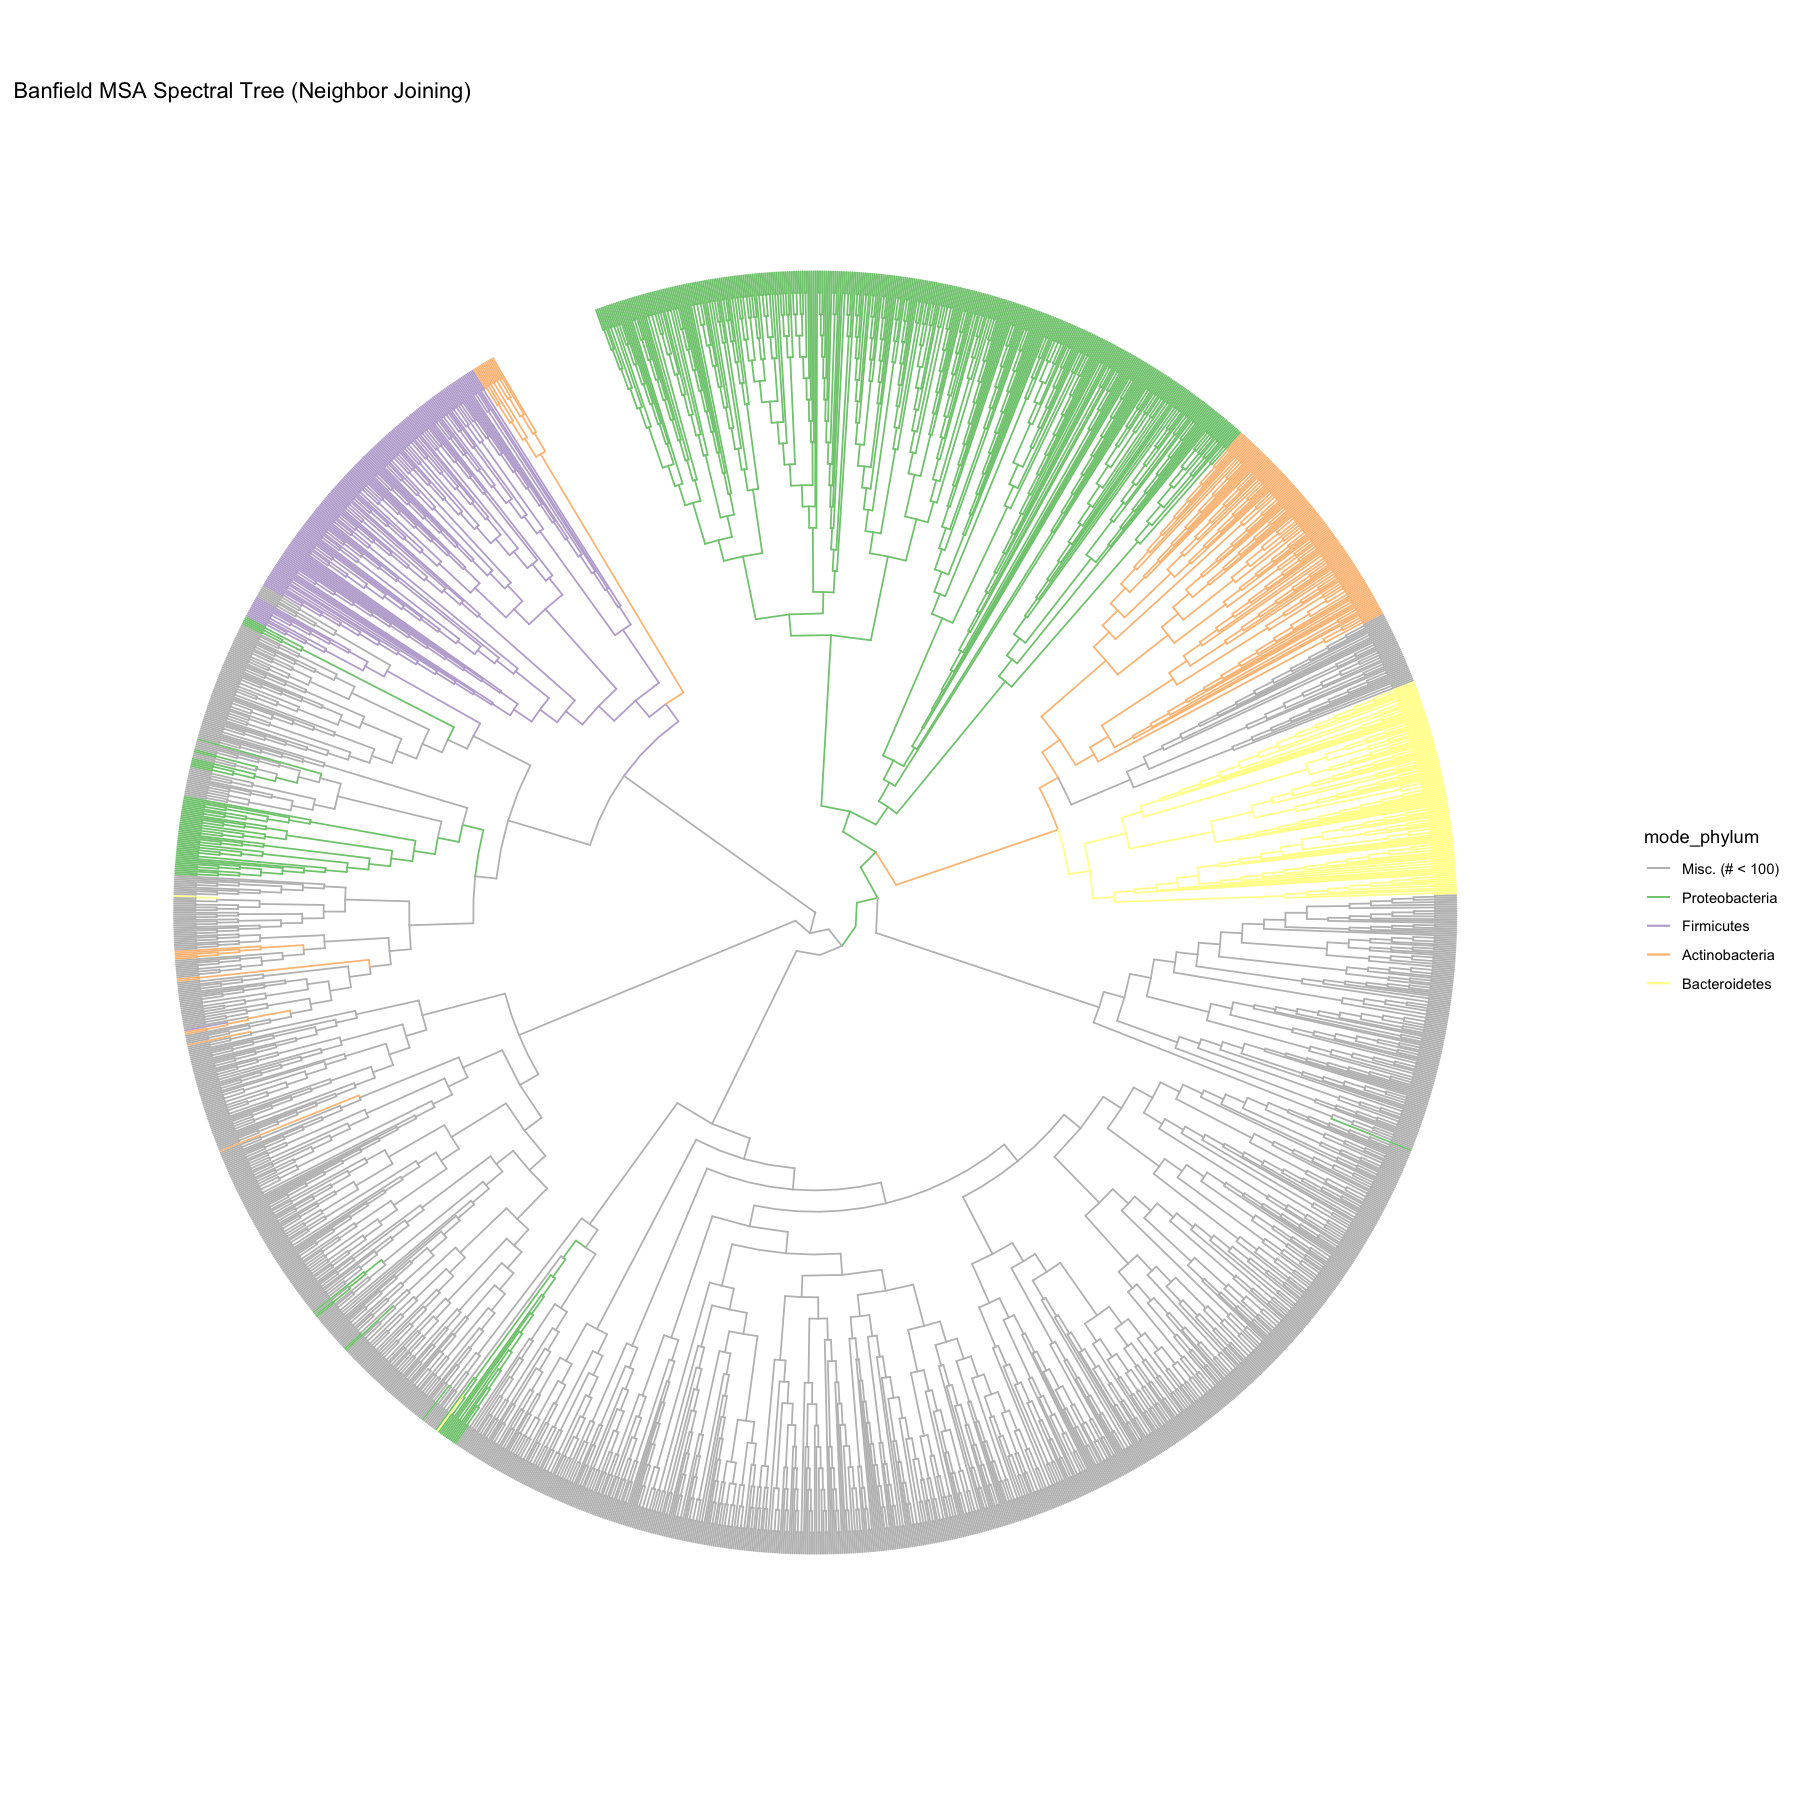

In [45]:
options(repr.plot.width=15, repr.plot.height=15, ignore.negative.edge=TRUE)
colorvalues = c("grey", RColorBrewer::brewer.pal(4, name="Accent"), "darkgrey")
ggtree(banfield_spitree_withdata, 
    aes(color=mode_phylum), 
    layout="fan", open.angle=10,
    branch.length="none",
    )  %>% rotate_tree(-240) +
    ggtitle("Banfield MSA Spectral Tree (Neighbor Joining)") + 
    scale_color_manual(values=colorvalues, breaks=c("Misc. (# < 100)", names(biggerphylum), "unknown")) #+theme(legend.position="none")

In [21]:
ggsave(file.path(pdir, "Banfield_SPItree_coloredbyPhylum_justbacteria.pdf"), 
    height=7,
    width=7,
)

In [46]:
unique(as_tibble(banfield_spitree_withdata)$phylum) %>% length

[1] 109

## Uniprot tree

In [65]:
updir = file.path(getwd(), "data", "exp_raw", "UP7047")
uptreedir = file.path(getwd(), "_research", "UP7047_neighborjoined_spitree")

In [64]:
uniprot_spitree = read.newick(file.path(uptreedir, "2020_02_UP7047-supporttree.nw"), node.label='support')

In [271]:
uplineage = read.csv(file.path(updir, "UProwmeta.csv"))
uplineage$label = uplineage$Proteome_ID

biggerphyla  = sort(table(uplineage$Phylum), decreasing = TRUE)[sort(table(uplineage$Phylum), decreasing = TRUE) > 100]
bigPhylum = uplineage$Phylum
bigPhylum[!(bigPhylum %in% names(biggerphyla))] = "Misc. (# < 100)"
uplineage$bigPhylum = bigPhylum

uniprot_spitree_withdata = as.treedata(left_join(as_tibble(uniprot_spitree), uplineage, by='label'))
utree_tbl = as_tibble(uniprot_spitree_withdata)

mode_phylum = offspring(utree_tbl, utree_tbl$node, tiponly = FALSE, self_include = TRUE)
mode_phylum = unlist(lapply(mode_phylum, function(x) modeest::mfv1(x$bigPhylum, na_rm=TRUE)))

utree_tbl$mode_phylum = mode_phylum
uniprot_spitree_withdata = as.treedata(utree_tbl)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



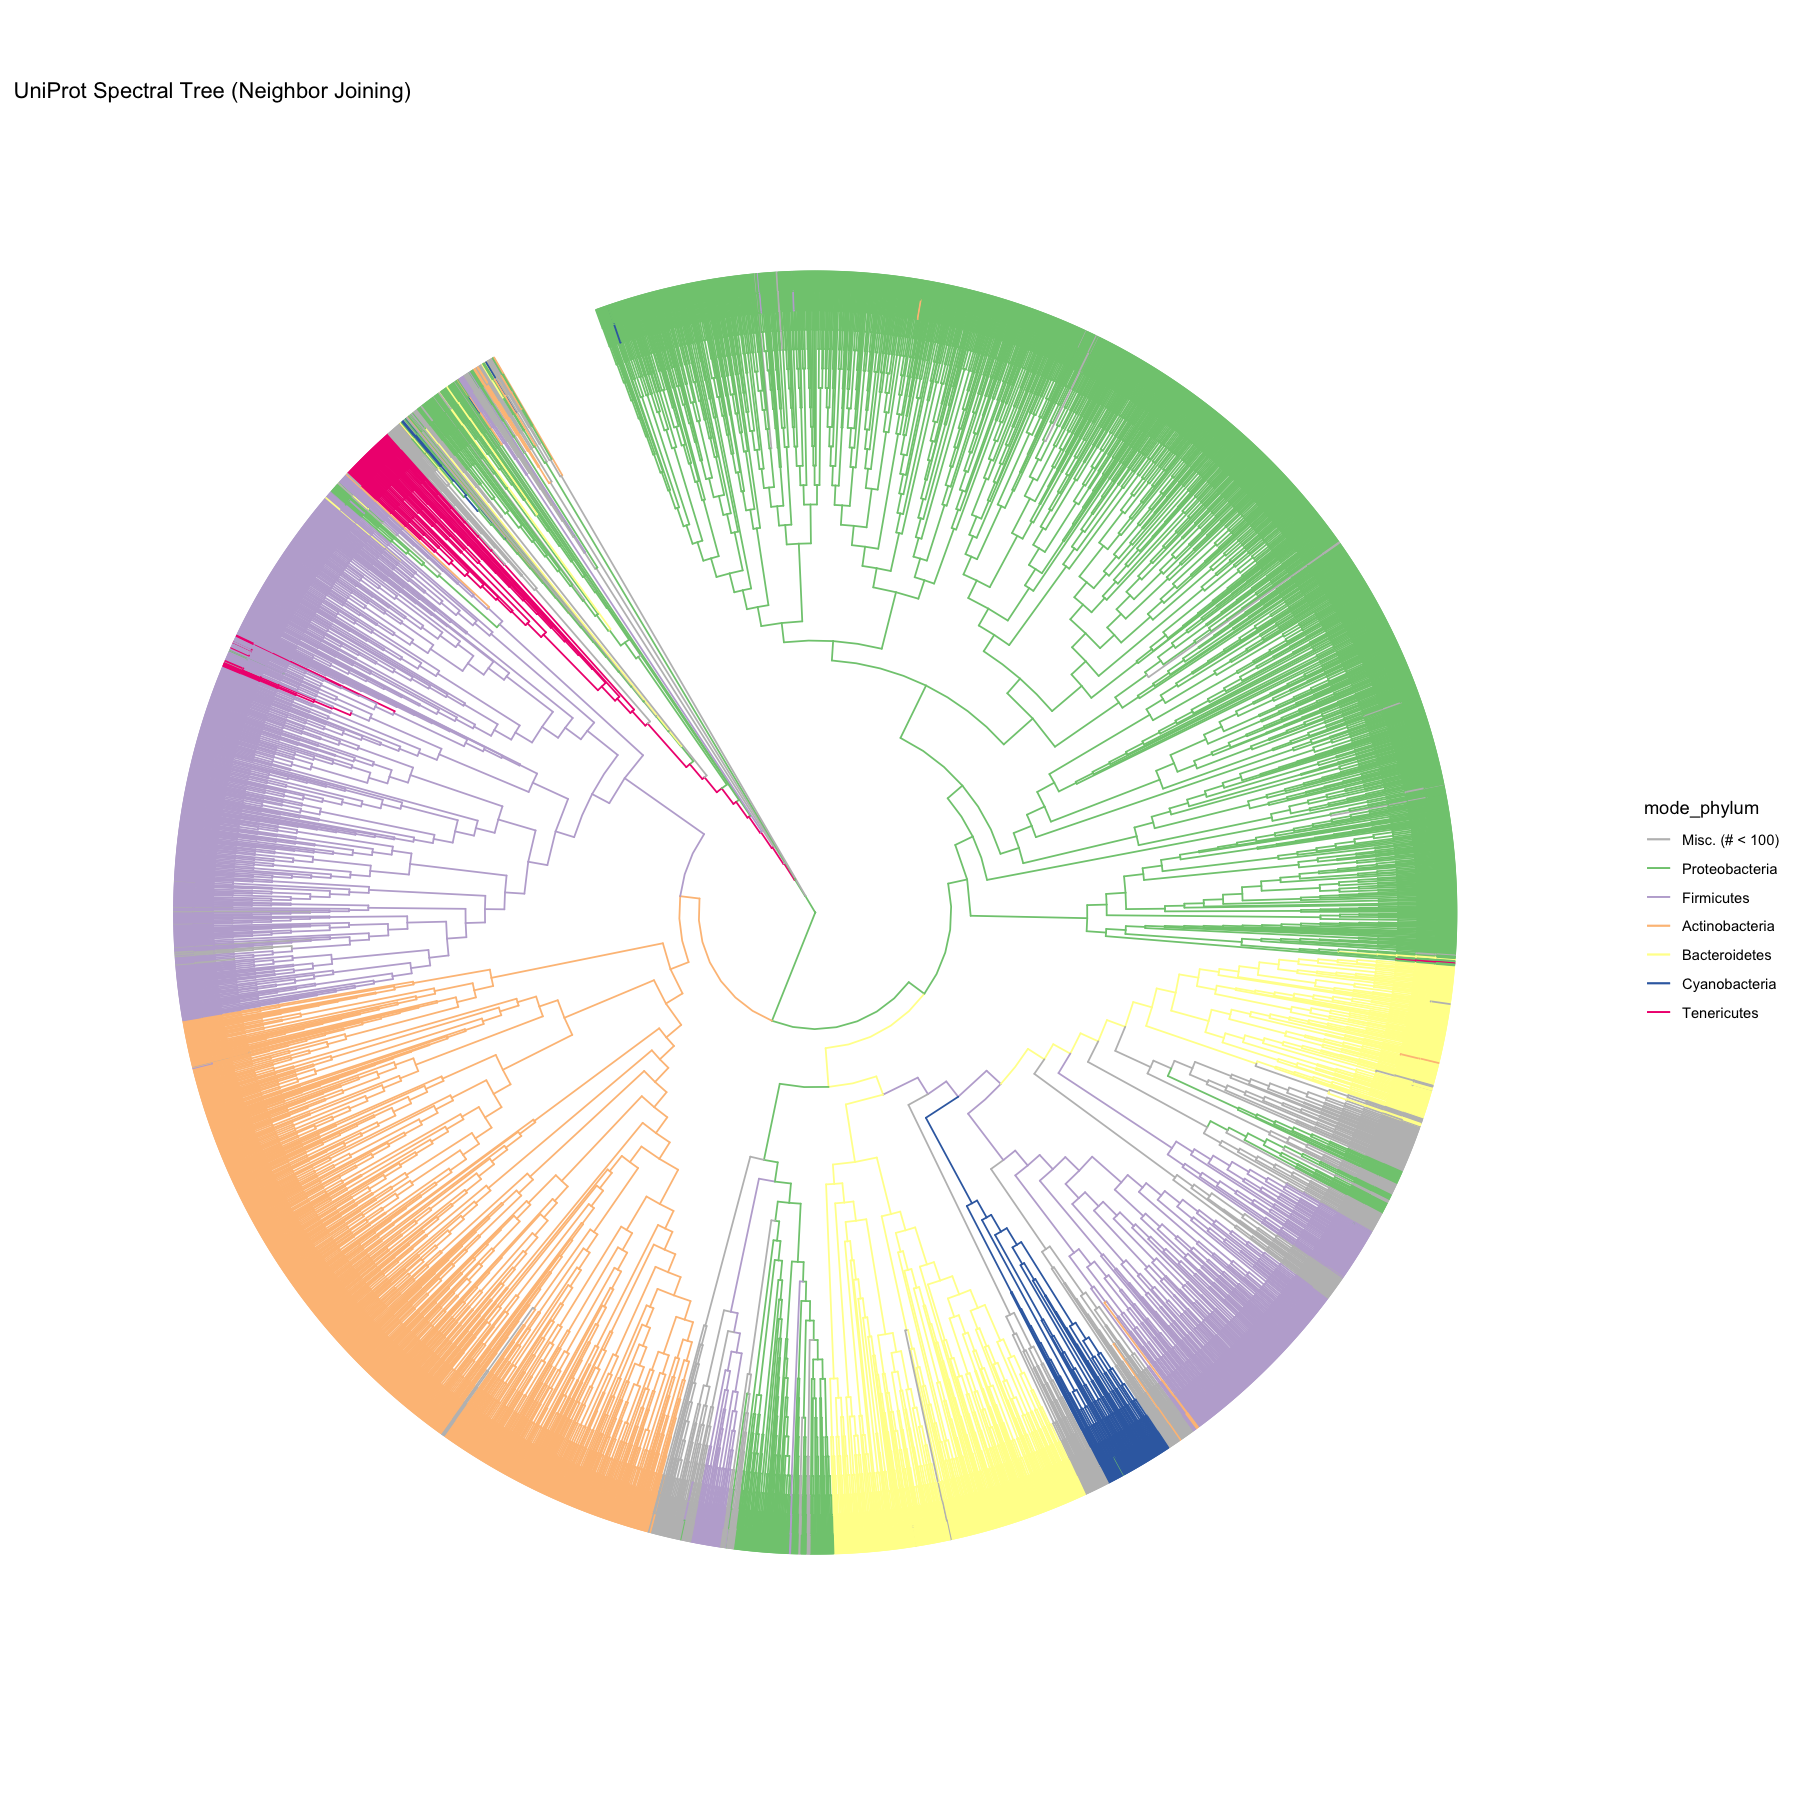

In [272]:
options(repr.plot.width=15, repr.plot.height=15, ignore.negative.edge=TRUE)
colorvalues = c("grey", RColorBrewer::brewer.pal(6, name="Accent"), "grey")
ggtree(uniprot_spitree_withdata, 
    aes(color=mode_phylum), 
    layout="fan", open.angle=10,
    branch.length="none",
    )  %>% rotate_tree(-240) +
    ggtitle("UniProt Spectral Tree (Neighbor Joining)") + 
    scale_color_manual(values=colorvalues, breaks=c("Misc. (# < 100)", names(biggerphyla), "unknown")) #+theme(legend.position="none")

In [273]:
ggsave(file.path(pdir, "UniProt_SPItree_coloredbyPhylum.pdf"), 
    height=7,
    width=7,
)

## SPI tree of CSB Biobank

In [8]:
bb669obs = read.table(file.path(getwd(), "data/exp_pro/BB669/BB669_rowmeta.csv"), sep=",", header=1)
# bb669obs$family[bb669obs$genus == "Phocaeicola"] = "Bacteroidaceae" # genus Phocaeicola are in family Bacteroidaceae
bb669obs$family_ncbi[bb669obs$family_ncbi == "<unclassified>"] = "<unknown family>"
bb669tree = read.newick(file.path(getwd(), "data/exp_pro/BB669/BB669_inferred_spitree_nj.nw"))
bb669tree = as.treedata(left_join(as_tibble(bb669tree), bb669obs, by = c("label" = "ID")))

In [11]:
bb669tree_tbl = as_tibble(bb669tree)

mode_family = offspring(bb669tree_tbl, bb669tree_tbl$node, tiponly = FALSE, self_include = TRUE)
mode_family = unlist(lapply(mode_family, function(x) modeest::mfv1(x$family_ncbi, na_rm=TRUE)))

bb669tree_tbl$mode_family = mode_family
bb669tree = as.treedata(bb669tree_tbl)

In [12]:
familynames = names(sort(table(bb669obs$family_ncbi), decreasing = TRUE))

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


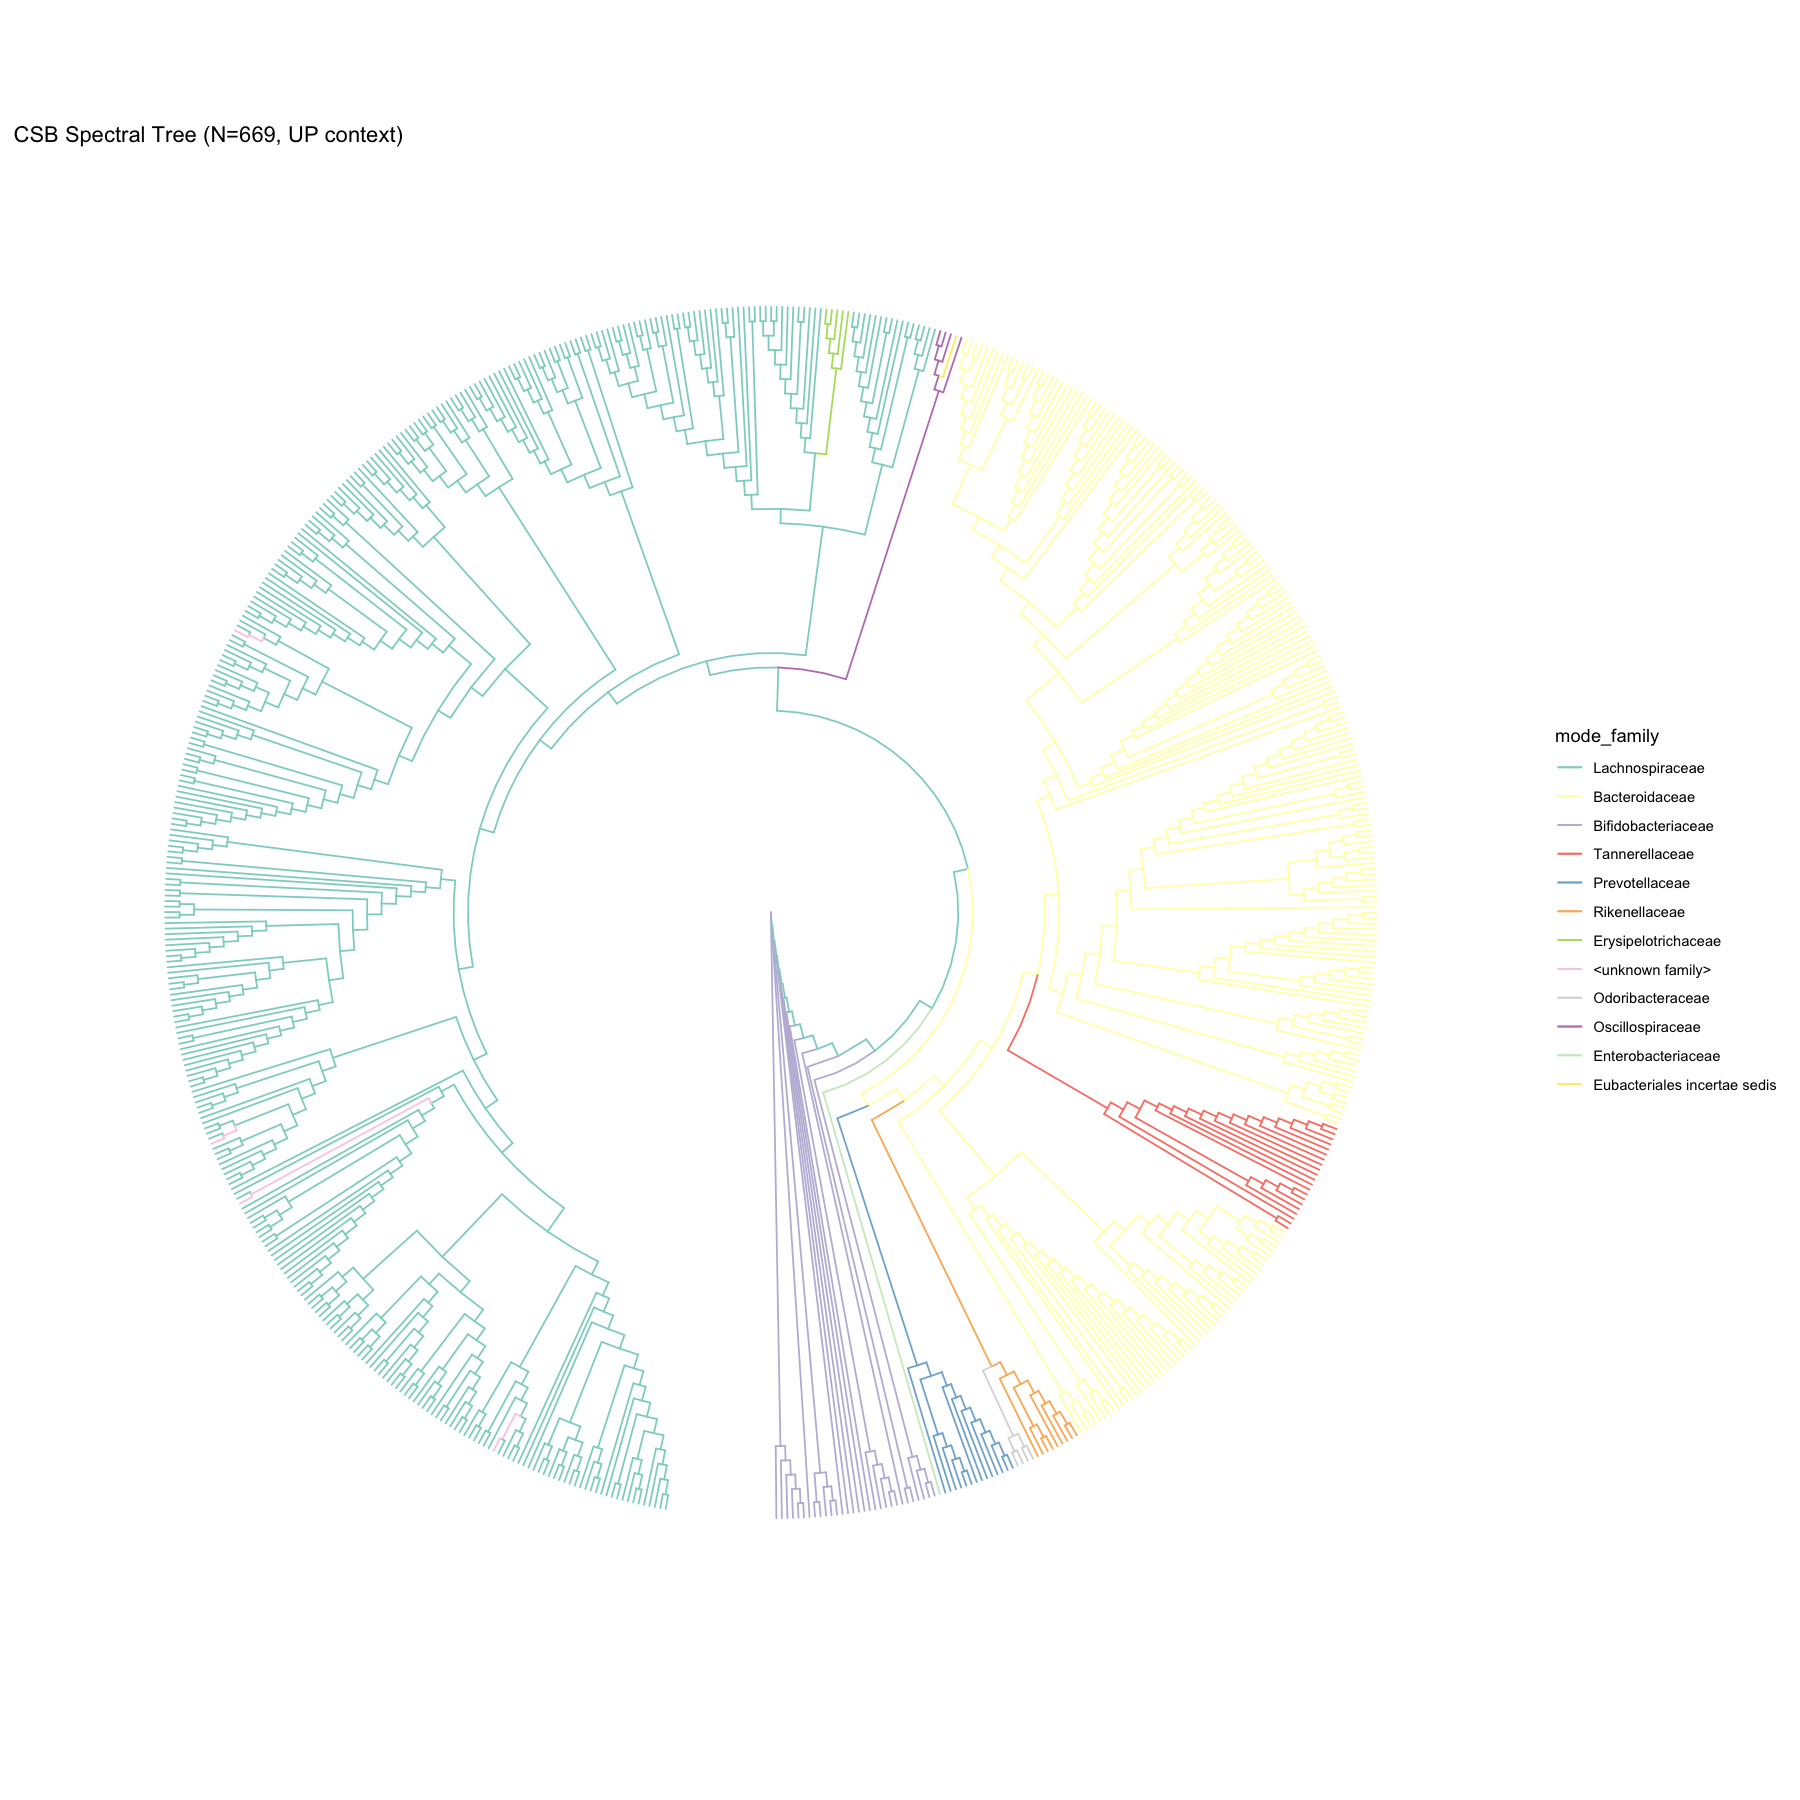

In [13]:
options(repr.plot.width=15, repr.plot.height=15, ignore.negative.edge=TRUE)
colorvalues = RColorBrewer::brewer.pal(12, name="Set3")
ggtree(bb669tree, 
    aes(color=mode_family), 
    size=.5,
    layout="fan", open.angle=10,
    branch.length="none",
    )  %>% rotate_tree(-90) +
    ggtitle("CSB Spectral Tree (N=669, UP context)") + 
    scale_color_manual(values=colorvalues, breaks=familynames) #+theme(legend.position="none")

In [14]:
file.path(pdir, "CSB_spectraltree_n669_UPcontext.pdf")

[1] "/Users/bend/projects/Doran_etal_2022/plots/uniprot_and_banfield_spitrees/CSB_spectraltree_n669_UPcontext.pdf"

In [65]:
ggsave(file.path(pdir, "CSB_spectraltree_n669_UPcontext.pdf"), 
    height=7,
    width=7,
)

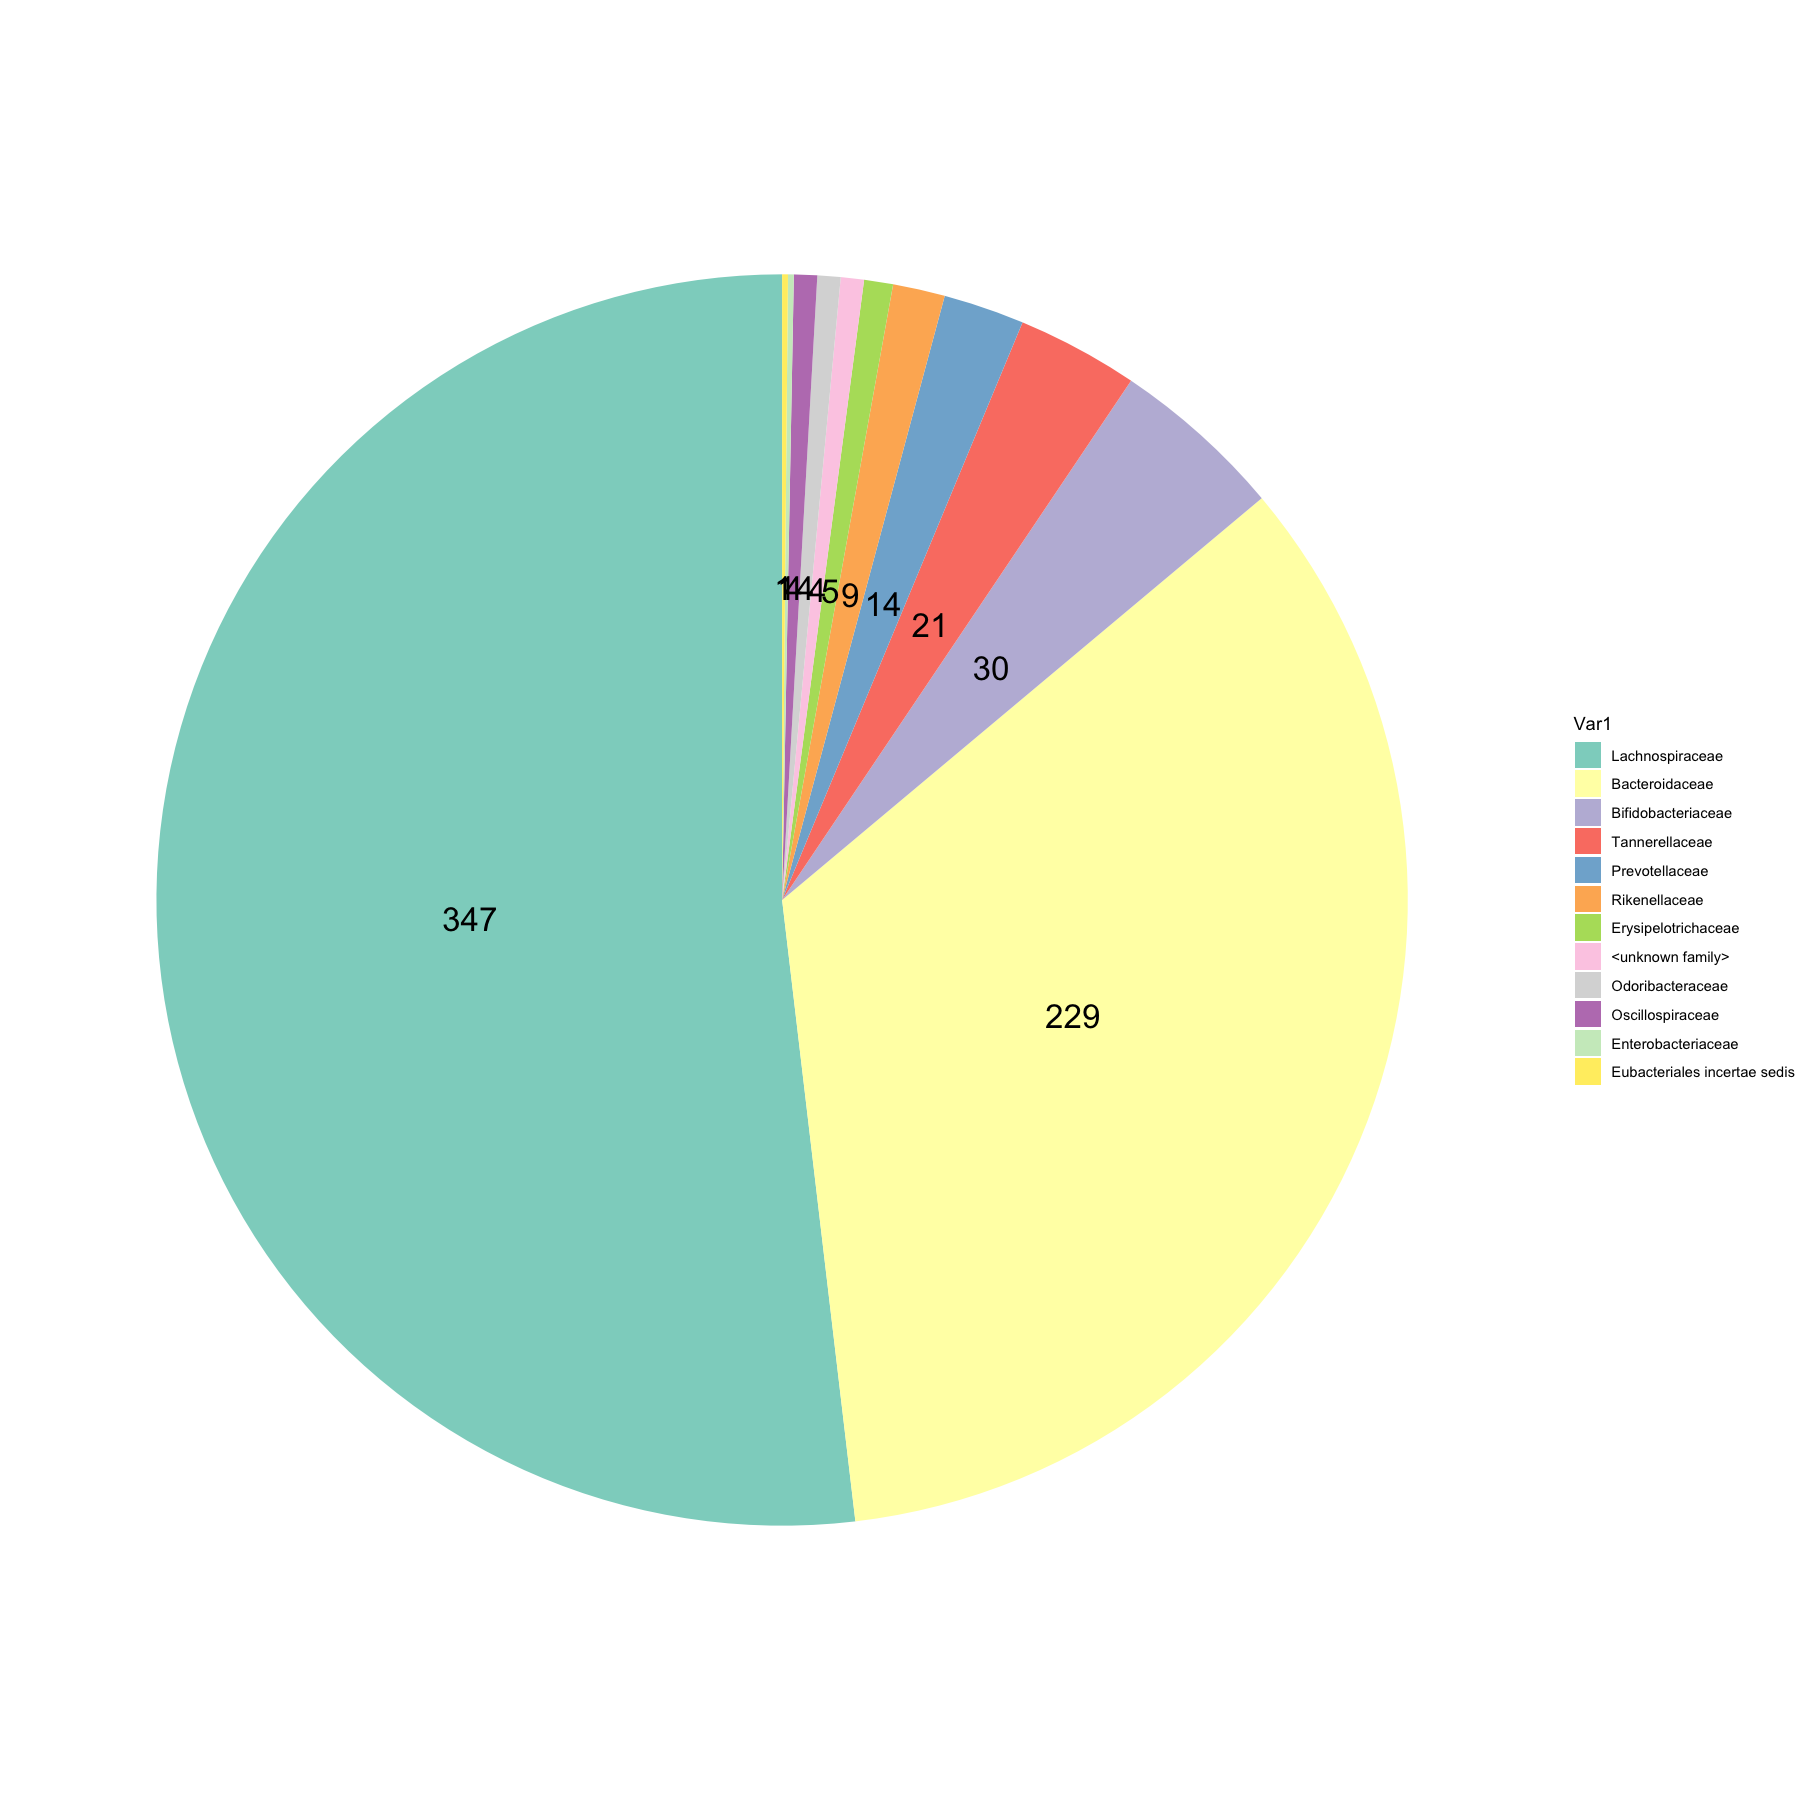

In [67]:
data.frame(sort(table(bb669obs$family_ncbi), decreasing = TRUE)) %>%
    ggplot() + 
        geom_col(aes(x="", y=Freq, fill=Var1)) + 
        geom_text(aes(x="", y=rev(Freq), label = rev(Freq)), size=7, position = position_stack(vjust = 0.5)) +
        coord_polar(theta="y") +
        scale_fill_manual(values=colorvalues, breaks=familynames) +
        theme_void()

In [68]:
ggsave(file.path(pdir, "CSB_familypiechart_n669_UPcontext.pdf"), 
    height=7,
    width=7,
)

### CSB 669 tree with tip labels

In [15]:
bb669tree_tbl = as_tibble(bb669tree)

mode_species = offspring(bb669tree_tbl, bb669tree_tbl$node, tiponly = FALSE, self_include = TRUE)
mode_species = unlist(lapply(mode_species, function(x) ifelse(length(unique(x$species_ncbi)) < 3, x$species_ncbi[1], NA)))

bb669tree_tbl$mode_species = mode_species
bb669tree = as.treedata(bb669tree_tbl)

In [16]:
bb669tree_tbl = as_tibble(bb669tree)

bb669tree_tbl$label = paste(str_pad(bb669tree_tbl$strain_id, 10, side="right"), bb669tree_tbl$species_ncbi, sep=" ")
bb669tree = as.treedata(bb669tree_tbl)

In [17]:
install.packages("scico")


The downloaded binary packages are in
	/var/folders/mq/7508lmkj2057tcbgnfx84bt00000gq/T//RtmpCZphR8/downloaded_packages


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


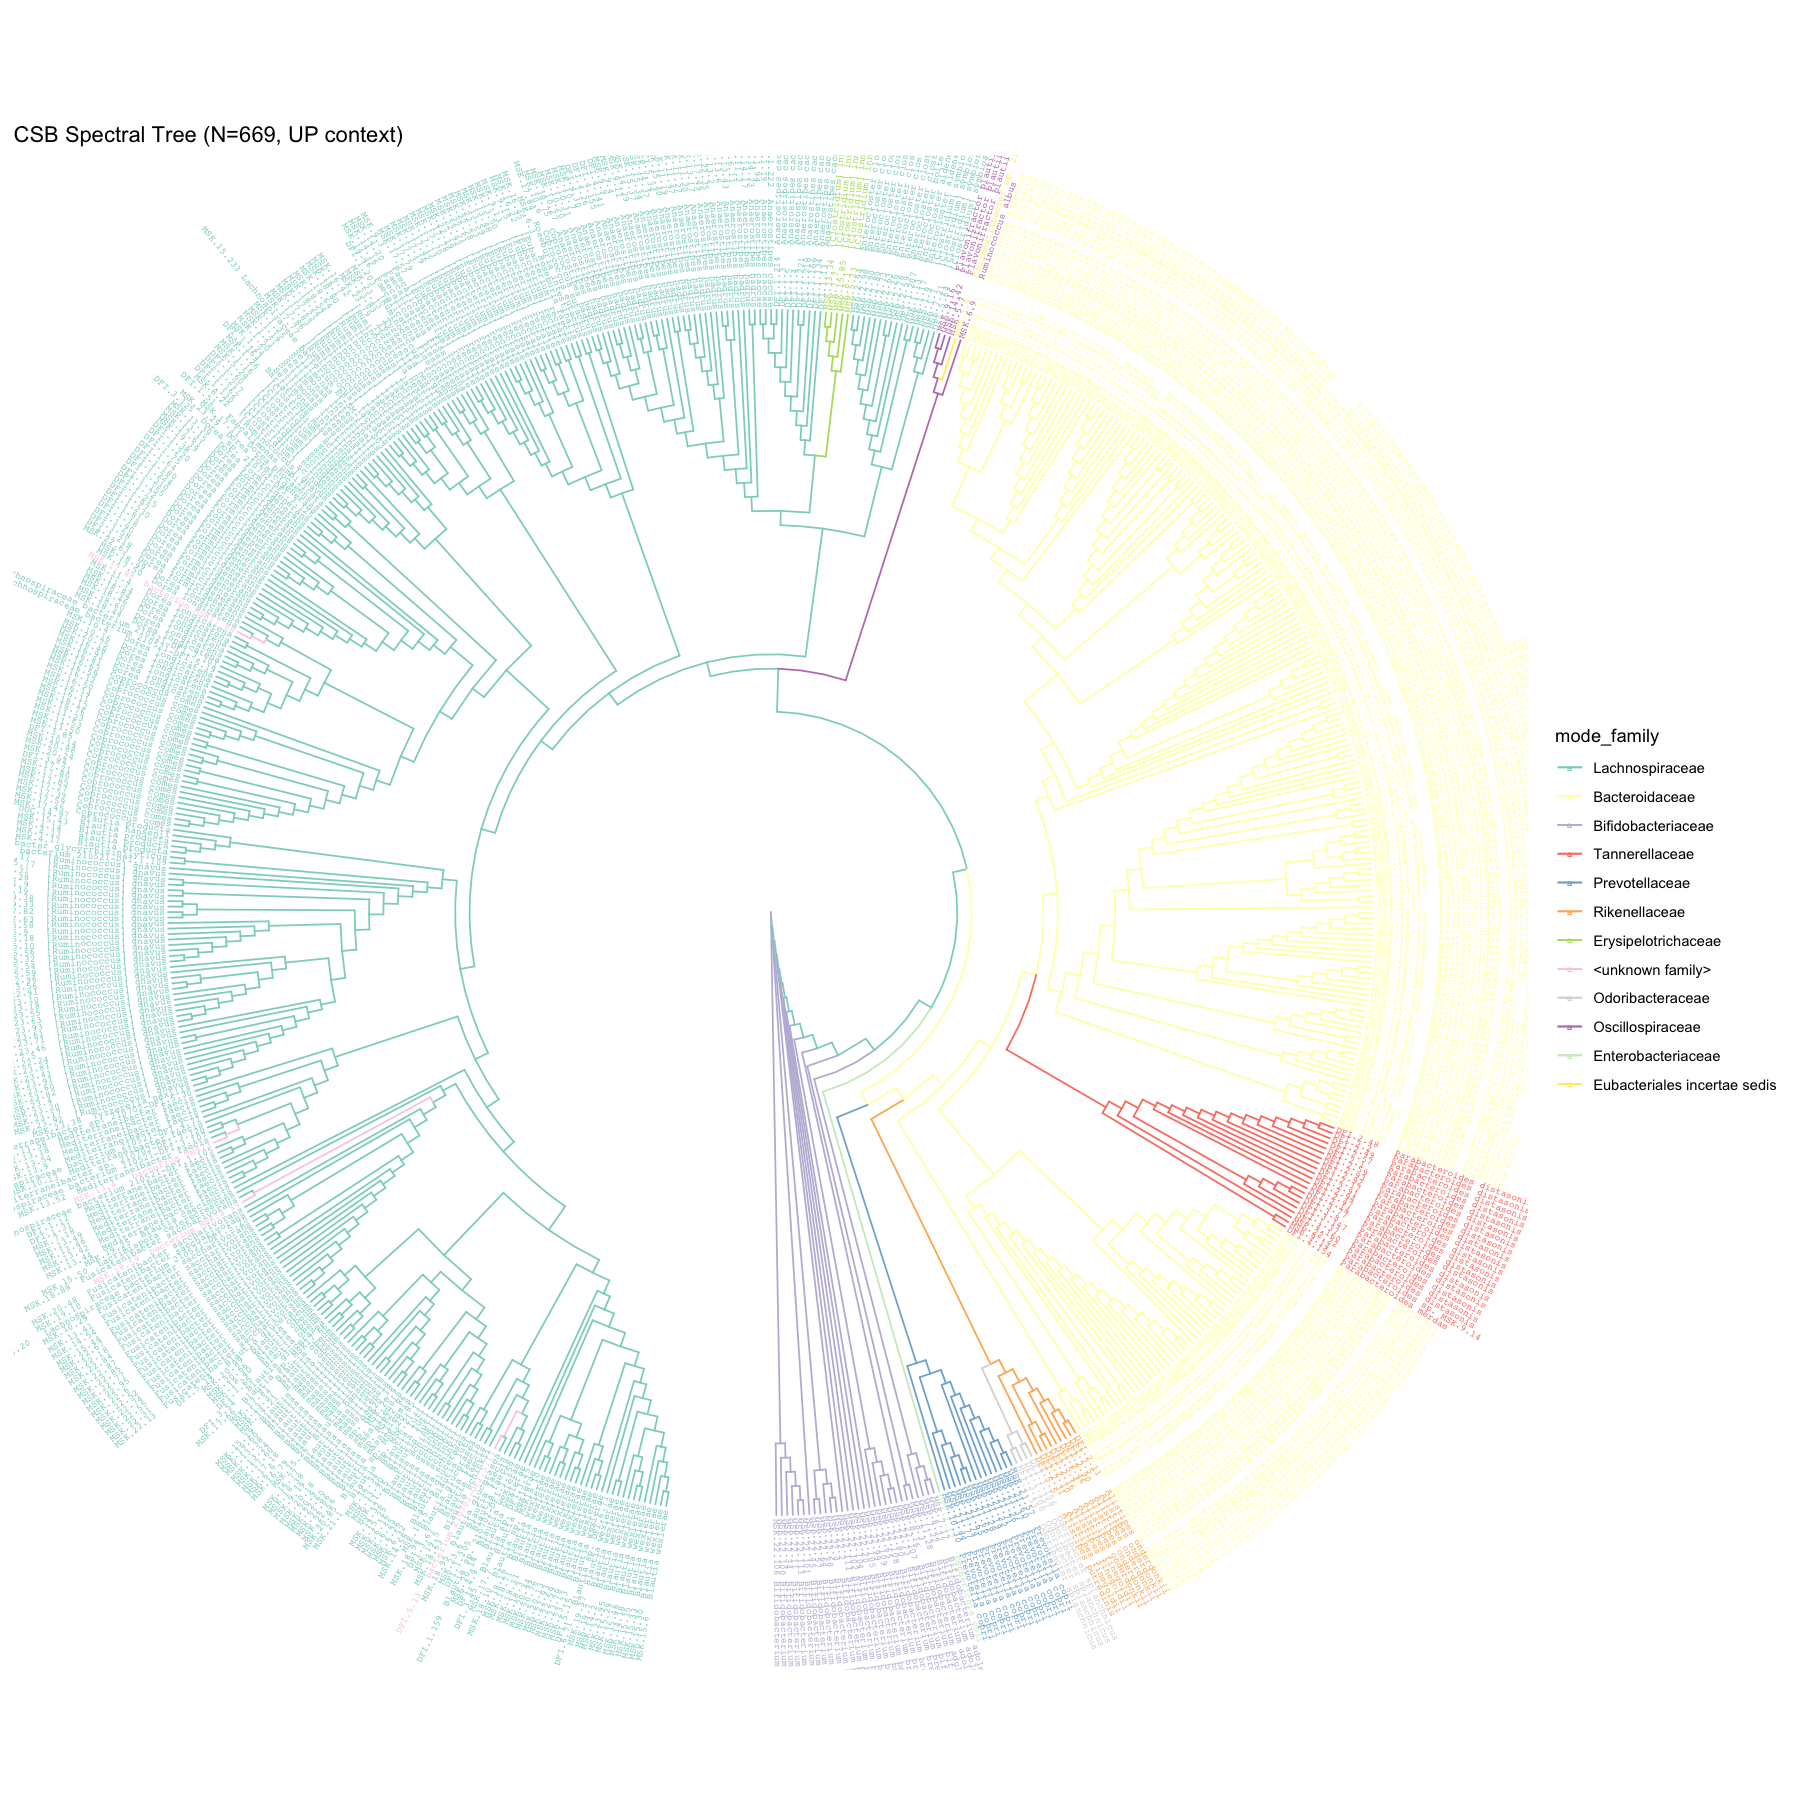

In [18]:
options(repr.plot.width=15, repr.plot.height=15, ignore.negative.edge=TRUE)
# colorvalues = RColorBrewer::brewer.pal(12, name="Set3")

ggtree(bb669tree, 
    aes(color=mode_family), 
    size=.5,
    layout="fan", open.angle=10,
    branch.length="none",
    )  %>% rotate_tree(-90) +
    geom_tiplab2(aes(text=paste(strain_id, species_ncbi)), size=2, family="mono") +
    ggtitle("CSB Spectral Tree (N=669, UP context)") +
    # ggsci::scale_color_futurama() #+
    # scico::scale_color_scico_d(palette="hawaii") +
    scale_color_manual(values=colorvalues, breaks=familynames) #+
    # theme(legend.position="none")

In [172]:
ggsave(file.path(pdir, "CSB_spectraltree_n669_UPcontext_with_tiplabels.pdf"), 
    height=15,
    width=15,
)

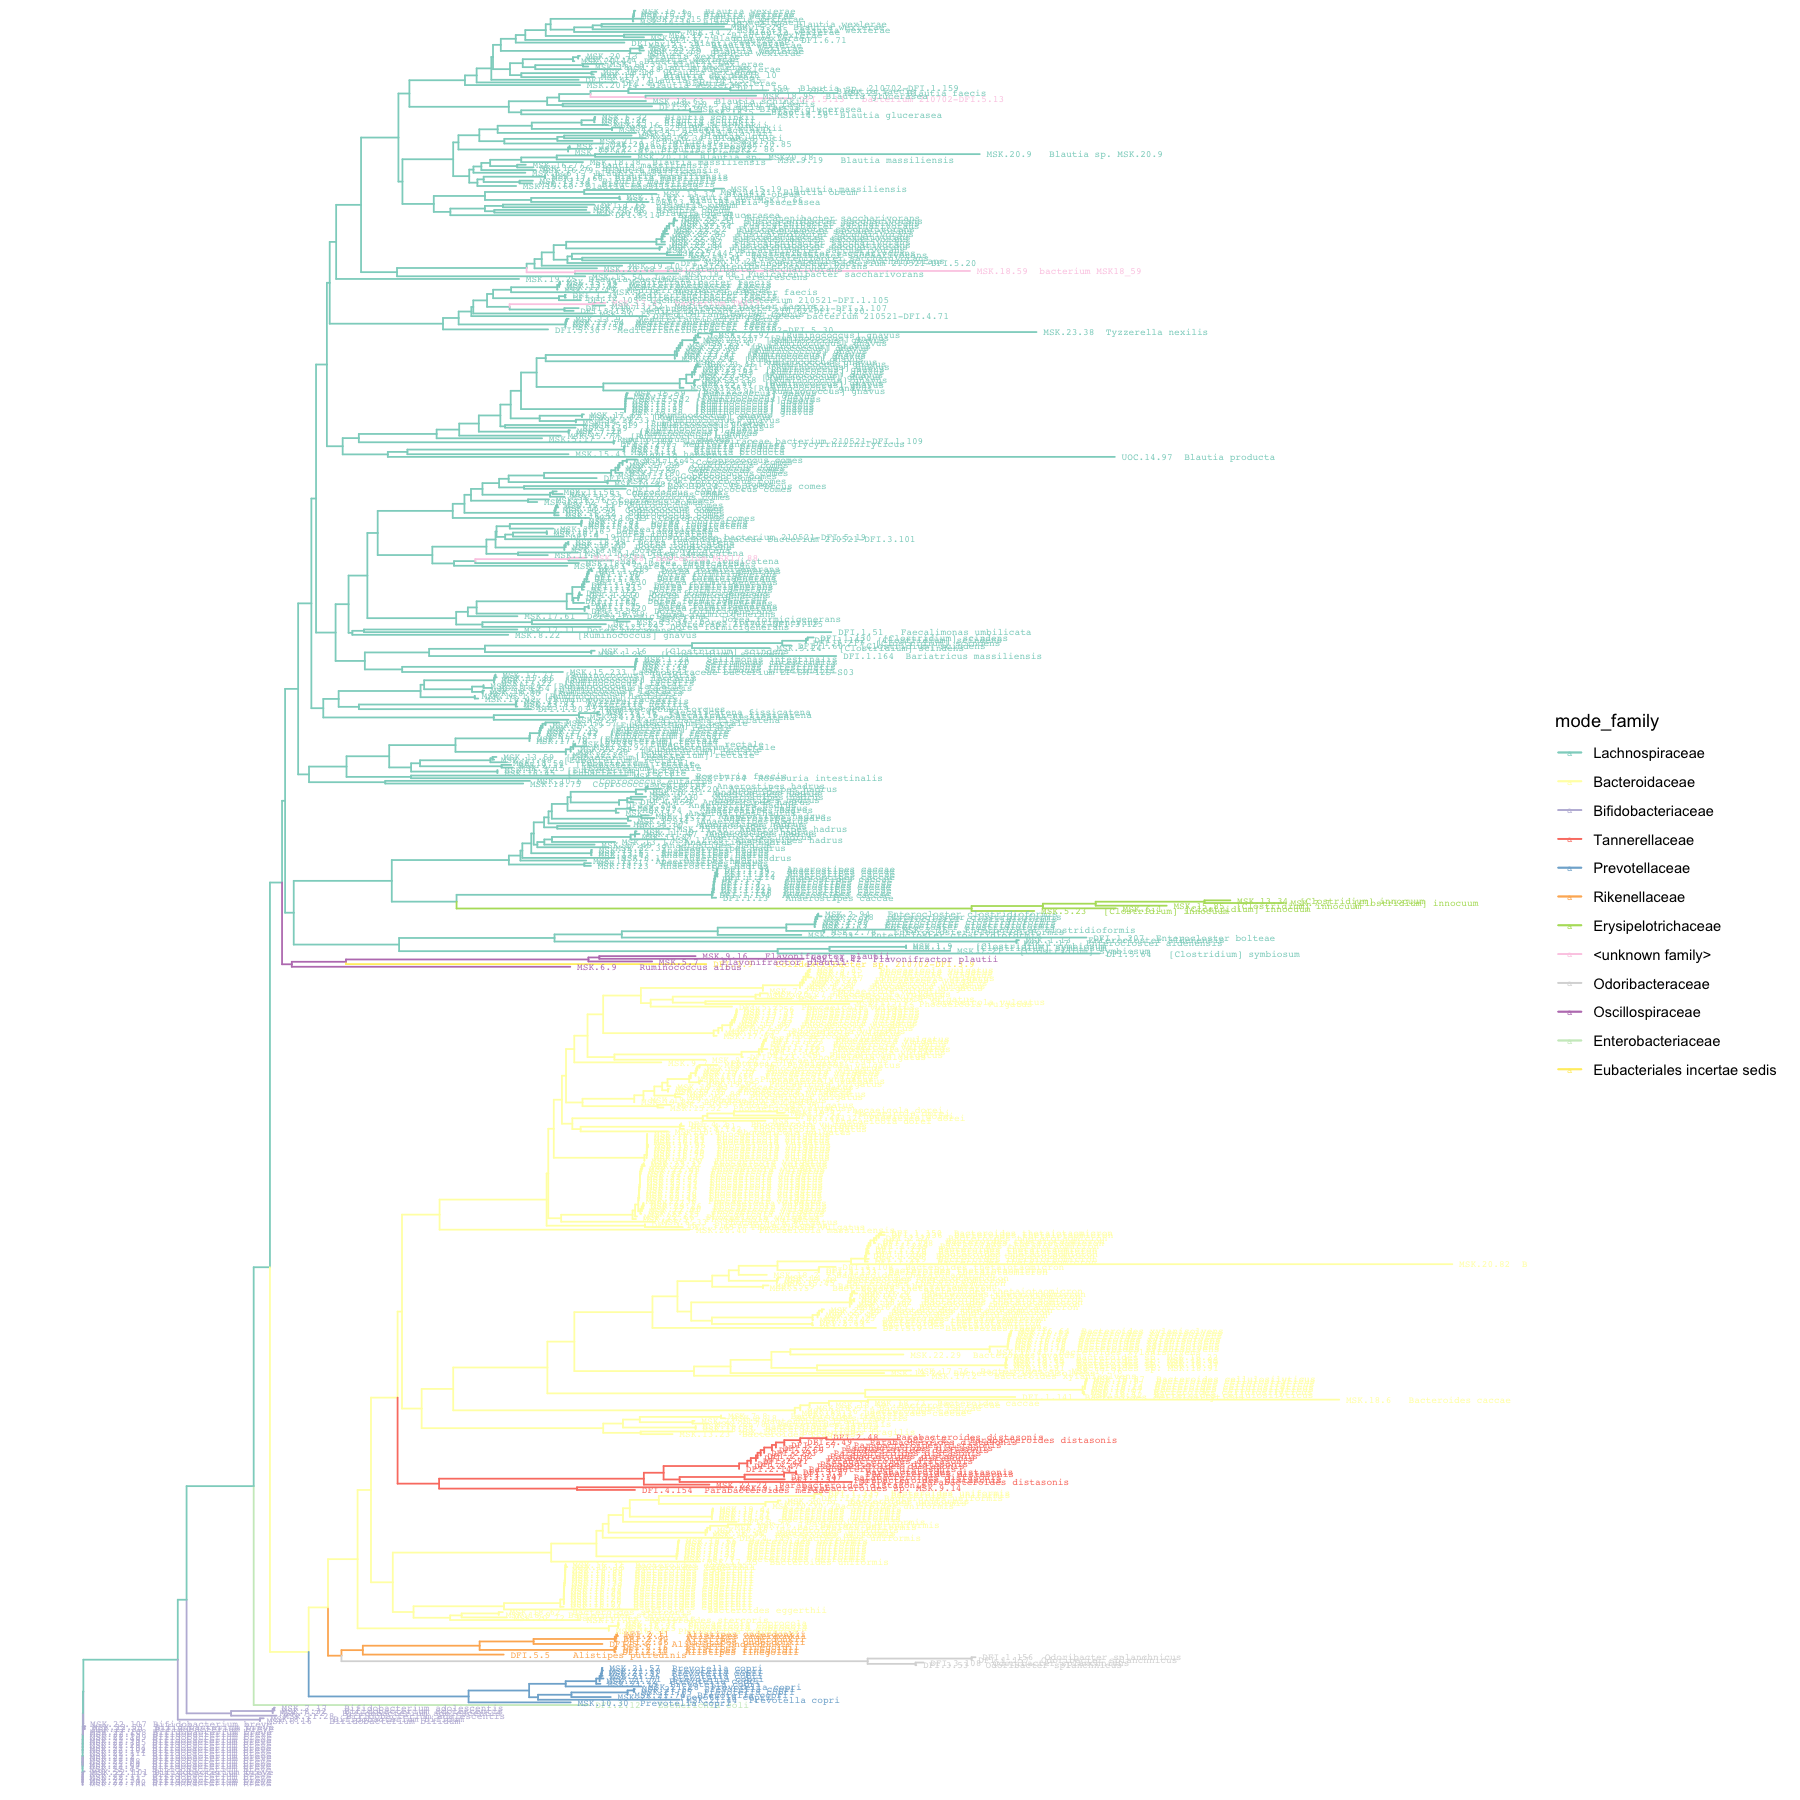

In [22]:
options(repr.plot.width=15, repr.plot.height=15, ignore.negative.edge=TRUE)
# colorvalues = RColorBrewer::brewer.pal(12, name="Set3")

ggtree(bb669tree, 
    aes(color=mode_family), 
    size=.5,
    layout="rect", open.angle=10,
    # branch.length="none",
    ) +
    geom_tiplab(aes(text=paste(strain_id, species_ncbi)), size=2, family="mono") +
    # ggtitle("CSB Spectral Tree (N=669, UP context)") +
    # ggsci::scale_color_futurama() #+
    # scico::scale_color_scico_d(palette="hawaii") +
    scale_color_manual(values=colorvalues, breaks=familynames) #+
    # theme(legend.position="none")

In [23]:
ggsave(file.path(pdir, "CSB_spectraltree_n669_UPcontext_with_tiplabels_layout-rect.pdf"), 
    height=15,
    width=15,
)

### Biobank with N=728

In [23]:
bb728obs = read.csv(file.path(getwd(), "data/exp_pro/BB728/BB728_obsdata.csv"), sep=",", header=1)
bb728obs$family[bb728obs$genus == "Phocaeicola"] = "Bacteroidaceae" # vulgatus are technically Bacteroidaceae now
bb728obs$family[bb728obs$family == ""] = "<unknown family>"
bb728tree = read.newick(file.path(getwd(), "data/exp_pro/bb728/inferrednewicktree_UP7047.nw"))
bb728tree = as.treedata(left_join(as_tibble(bb728tree), bb728obs, by = c("label" = "ID")))

In [24]:
bb728tree_tbl = as_tibble(bb728tree)

mode_family = offspring(bb728tree_tbl, bb728tree_tbl$node, tiponly = FALSE, self_include = TRUE)
mode_family = unlist(lapply(mode_family, function(x) modeest::mfv1(x$family, na_rm=TRUE)))

bb728tree_tbl$mode_family = mode_family
bb728tree = as.treedata(bb728tree_tbl)

In [25]:
familynames = names(sort(table(bb728obs$family), decreasing = TRUE))
colorvalues = RColorBrewer::brewer.pal(11, name="Set3")
colorvalues = c(colorvalues[1:6], "#CCCCCC", colorvalues[7:12])

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



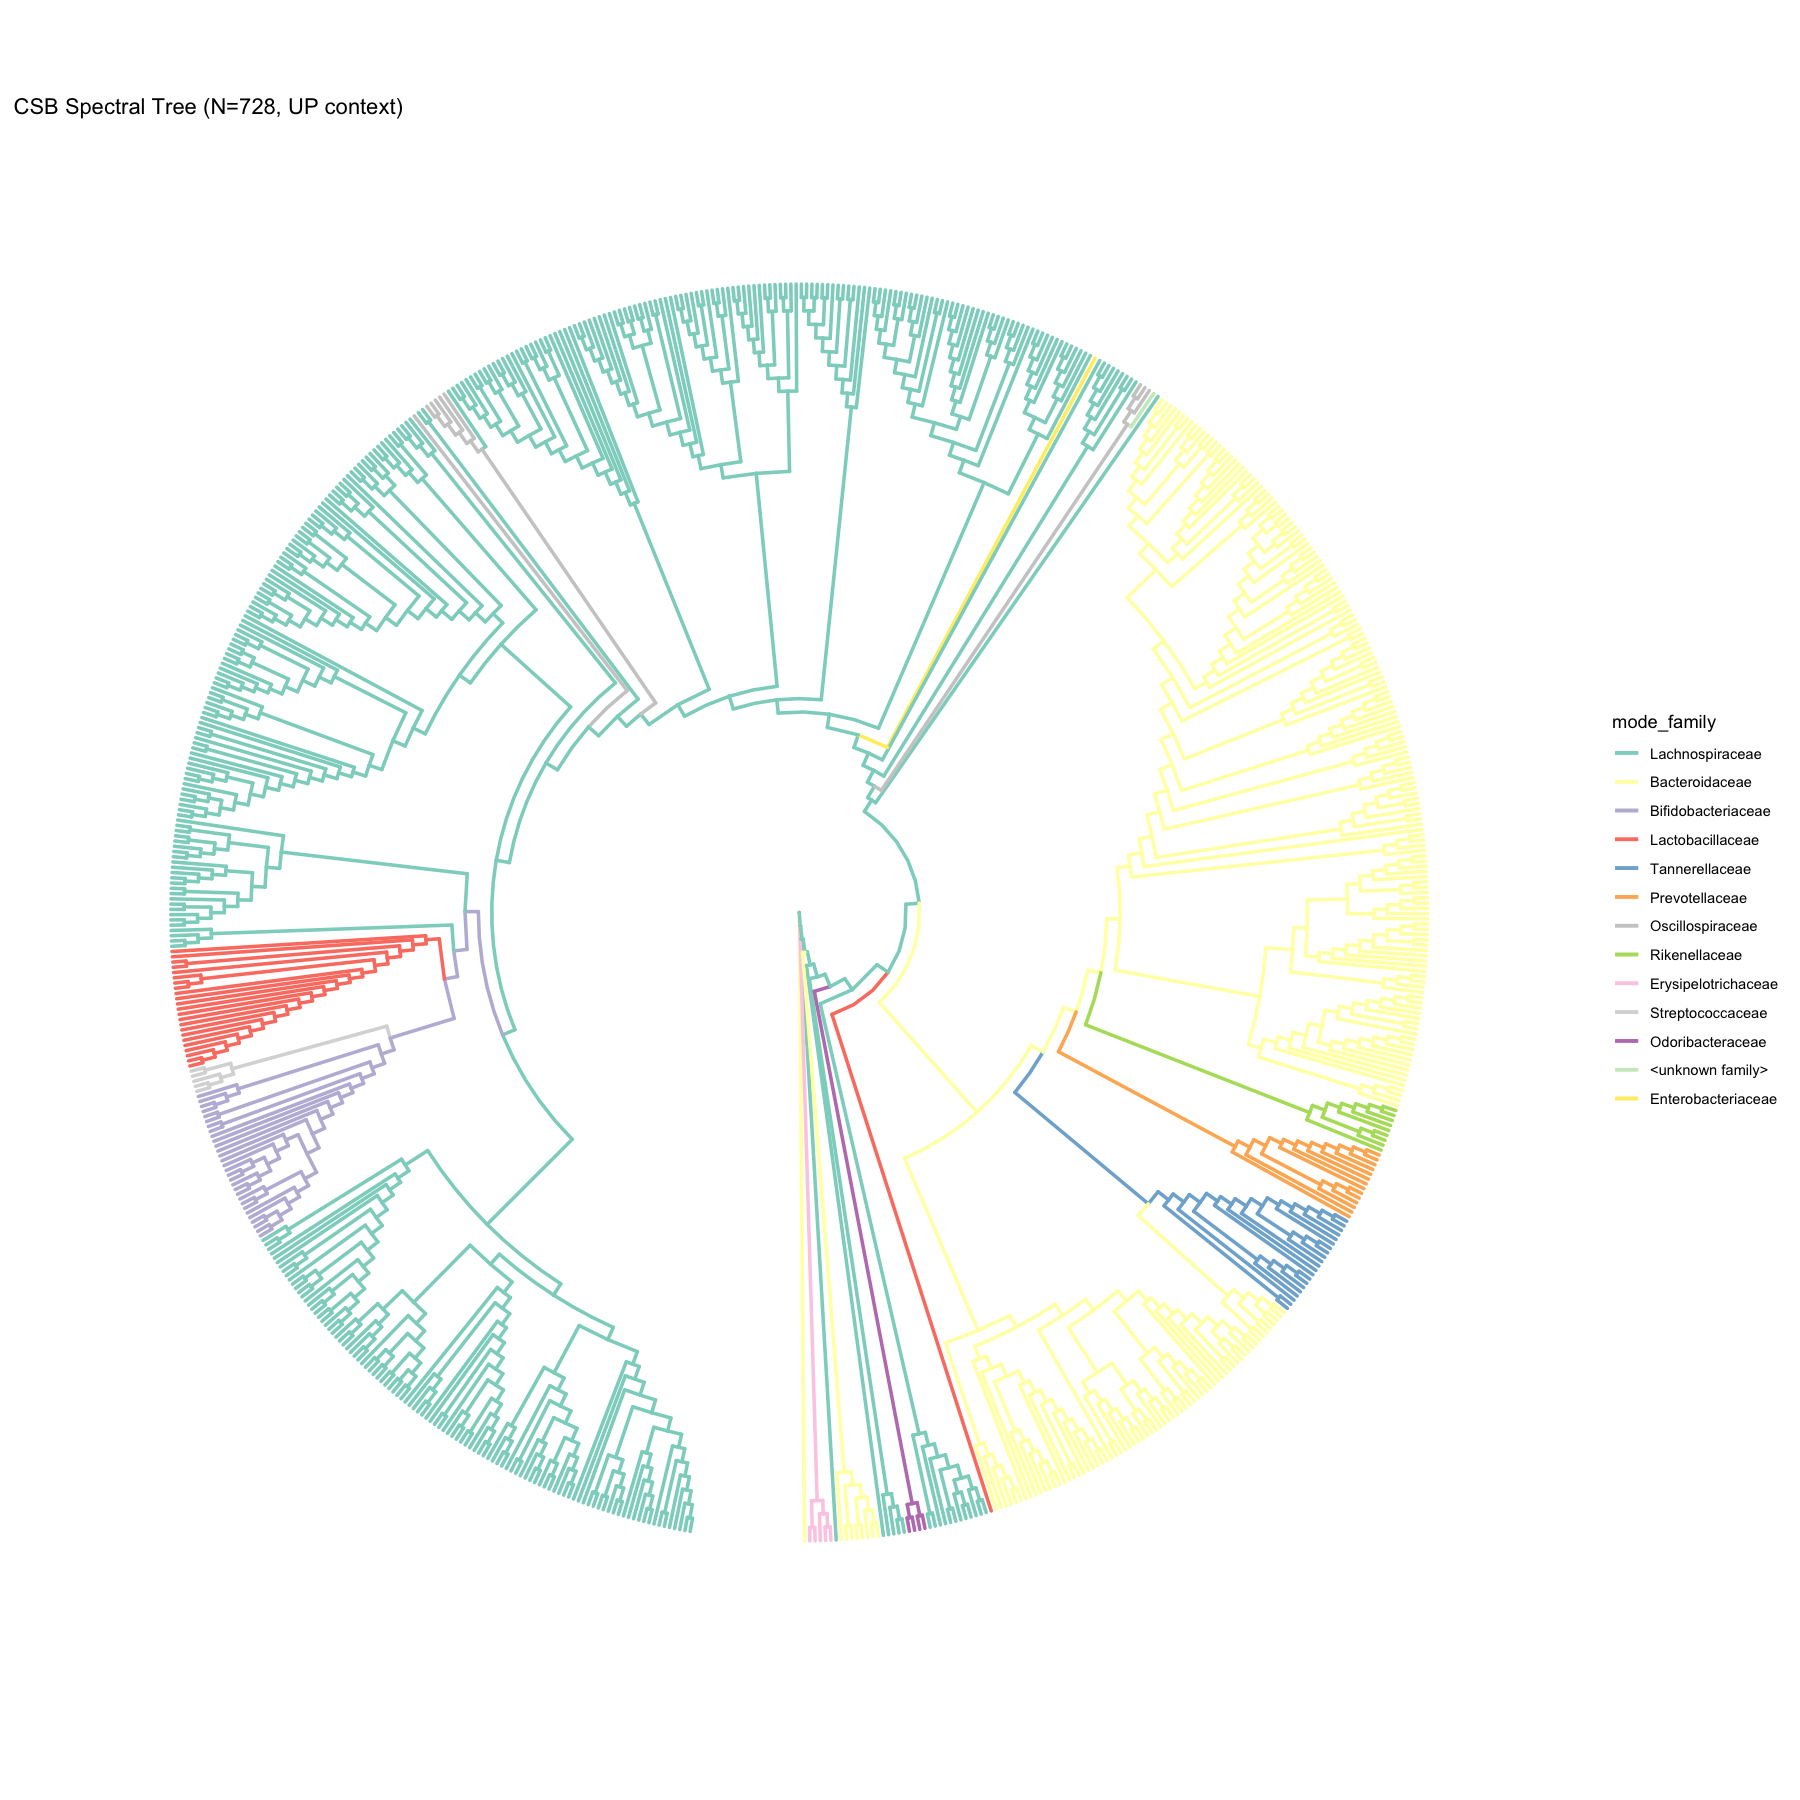

In [26]:
options(repr.plot.width=15, repr.plot.height=15, ignore.negative.edge=TRUE)
ggtree(bb728tree, 
    aes(color=mode_family), 
    size=1,
    layout="fan", open.angle=10,
    branch.length="none",
    )  %>% rotate_tree(-90) +
    ggtitle("CSB Spectral Tree (N=728, UP context)") + 
    scale_color_manual(values=colorvalues, breaks=familynames) #+theme(legend.position="none")

In [27]:
ggsave(file.path(pdir, "CSB_spectraltree_n728_UPcontext.pdf"), 
    height=7,
    width=7,
)

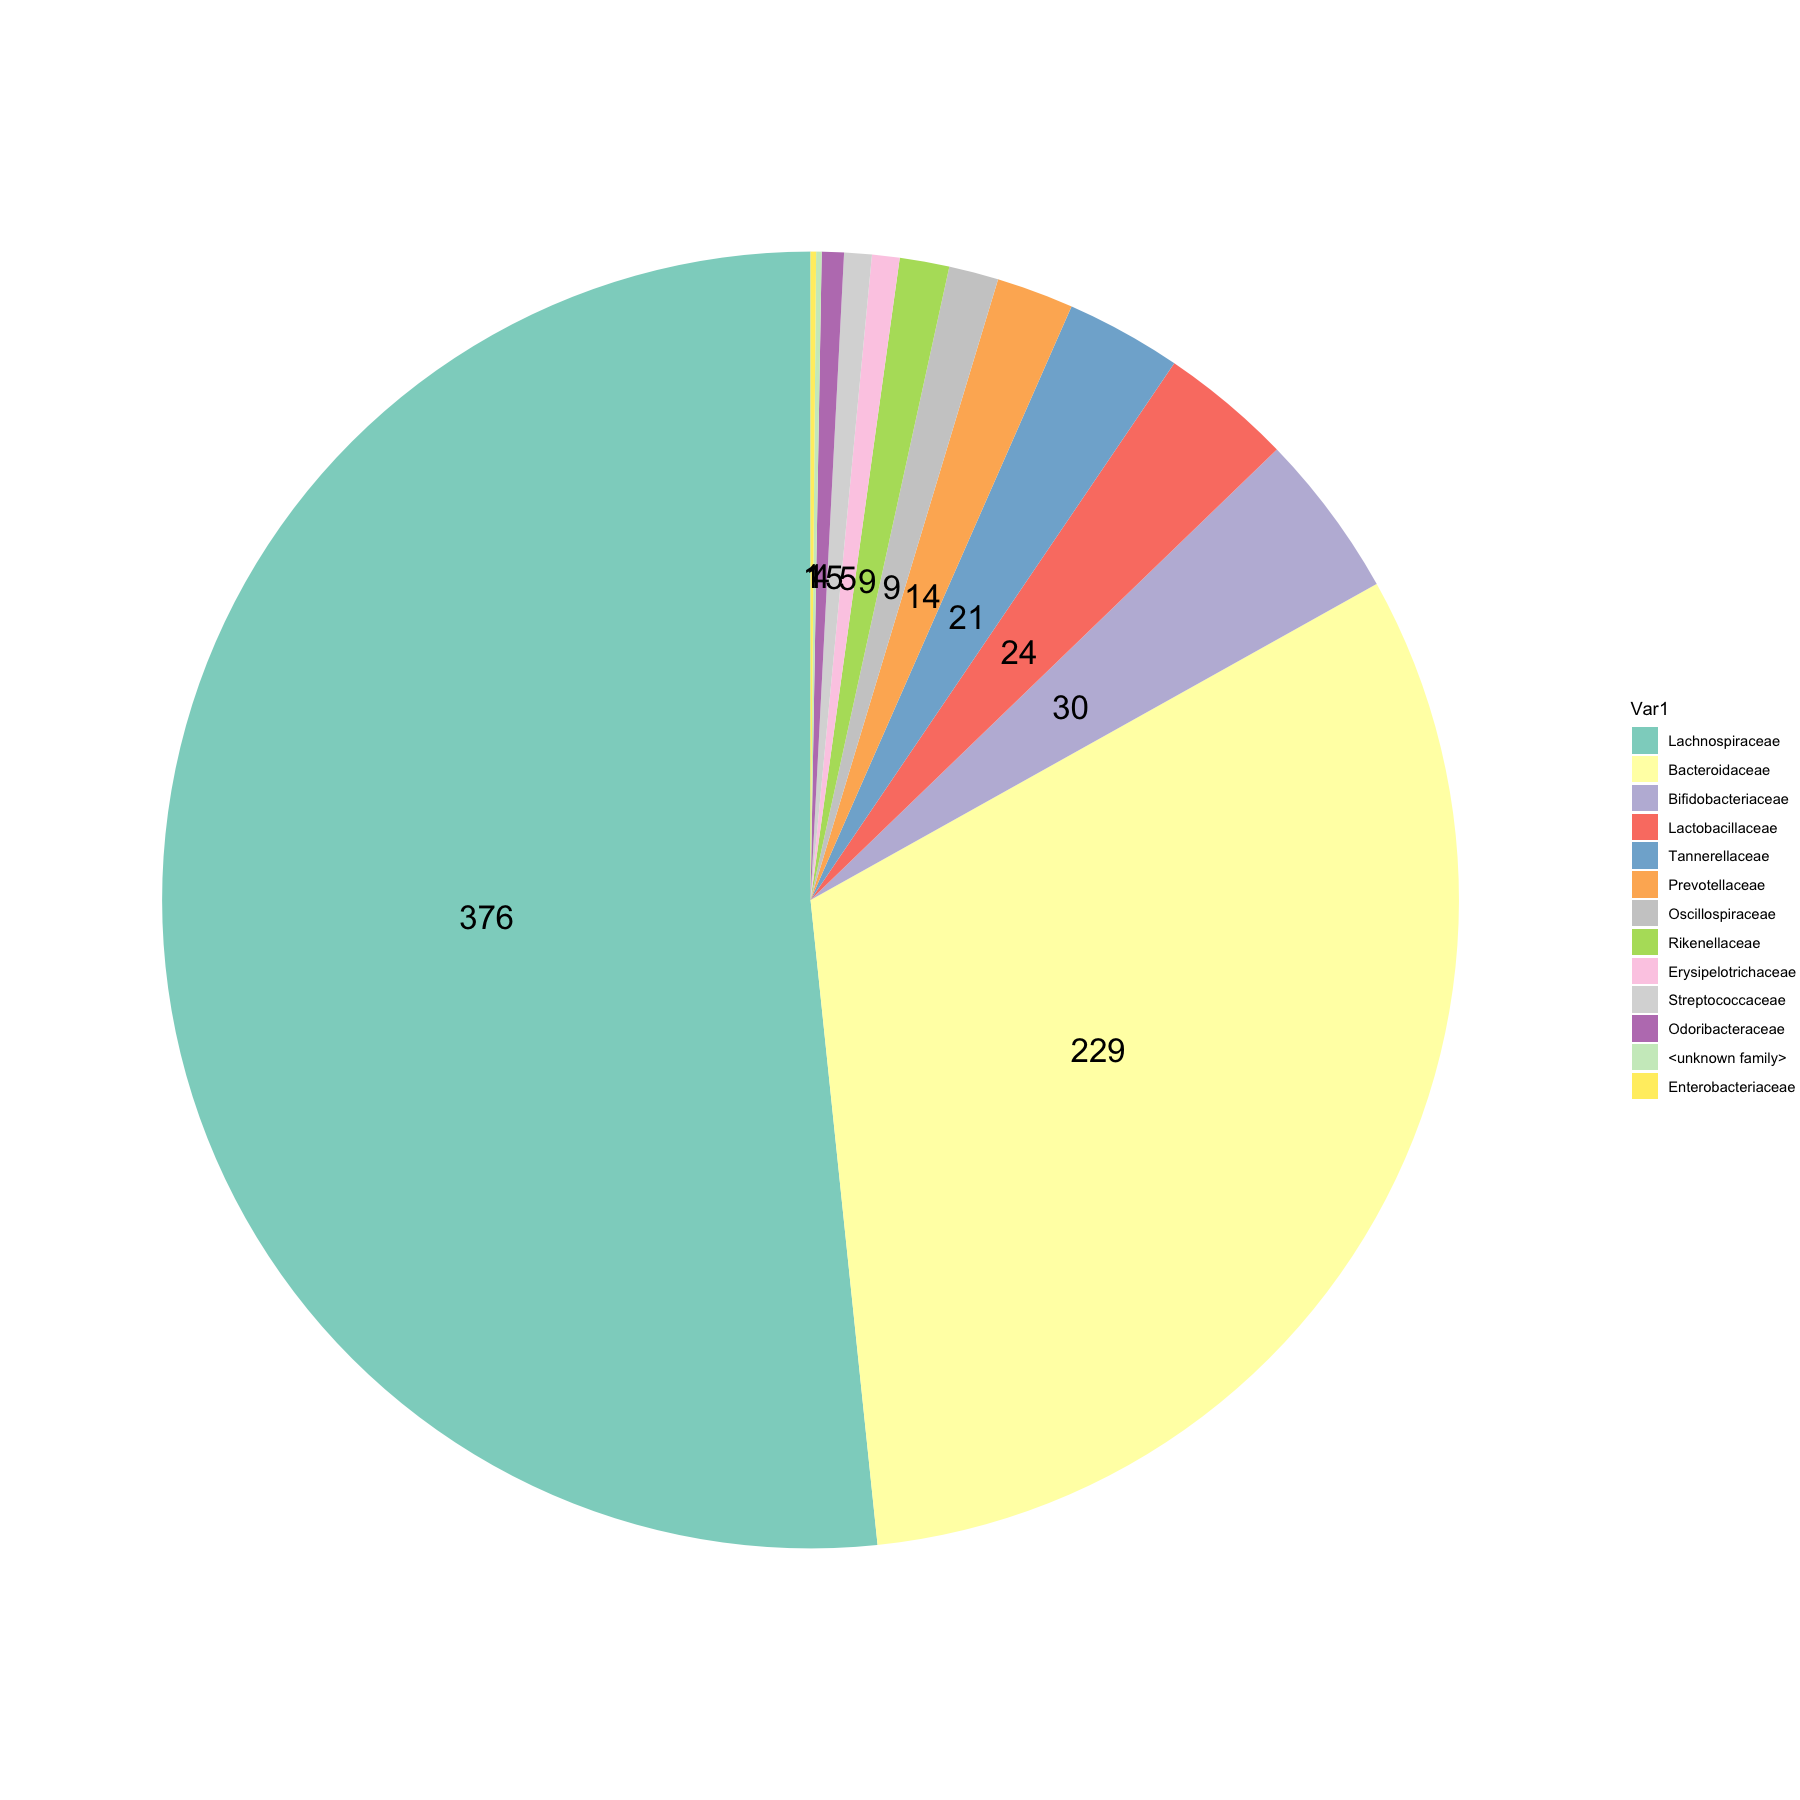

In [28]:
data.frame(sort(table(bb728obs$family), decreasing = TRUE)) %>%
    ggplot() + 
        geom_col(aes(x="", y=Freq, fill=Var1)) + 
        geom_text(aes(x="", y=rev(Freq), label = rev(Freq)), size=7, position = position_stack(vjust = 0.5)) +
        coord_polar(theta="y") +
        scale_fill_manual(values=colorvalues, breaks=familynames) +
        theme_void()

In [29]:
ggsave(file.path(pdir, "CSB_familypiechart_n728_UPcontext.pdf"), 
    height=7,
    width=7,
)